In [1]:
import sys

In [2]:
sys.path.append('./release/')

In [26]:
from IPython.display import clear_output

In [45]:
import pandas as pd

In [3]:
import numpy as np
from tqdm import tqdm, trange
import pickle
import os
from rdkit import Chem, DataStructs
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn import metrics
import torch

In [4]:
from data import PredictorData
from utils import get_fp, cross_validation_split, mol2image
from data import GeneratorData
from predictor import VanillaQSAR, PropertyPredictor
from sklearn.ensemble import RandomForestRegressor as RFR
from stackRNN import StackAugmentedRNN

from catboost import Pool, CatBoostClassifier

In [5]:
from PIL import Image
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

In [6]:
def get_scaffold(sm):
    mol = Chem.MolFromSmiles(sm)
    if mol: 
        return Chem.MolToSmiles(MurckoScaffold.GetScaffoldForMol(mol))

In [121]:
def draw_smiles(smiles_cur, prediction_cur, mols_to_draw=50, legends=None):
    prediction_cur = np.round( prediction_cur, 2)
    if mols_to_draw >= len(smiles_cur):
        ind = np.arange(0, len(smiles_cur))
    else:
        ind = np.random.randint(0, len(smiles_cur), min(mols_to_draw, len(smiles_cur)))
    mols_to_draw_max = [Chem.MolFromSmiles(smiles_cur[i], sanitize=True) for i in ind]
    if len(prediction_cur) > 0 and not legends:
        legends = [f'pIC50 jak1={prediction_cur[i][0]}; pIC50 jak2={prediction_cur[i][1]}; pIC50 jak3={prediction_cur[i][2]}'  
                   for i in ind]


      
    elif not legends:
        legends = []

    img = Draw.MolsToGridImage(mols_to_draw_max, molsPerRow=5,
                               subImgSize=(400, 400), legends=legends)
    return img

In [8]:
def get_generator(generator_model_path):
    tokens = ['<', '>', '#', '%', ')', '(', '+', '-', '/', '.', '1', '0', '3', '2', '5', '4', '7',
              '6', '9', '8', '=', 'A', '@', 'C', 'B', 'F', 'I', 'H', 'O', 'N', 'P', 'S', '[', ']',
              '\\', 'c', 'e', 'i', 'l', 'o', 'n', 'p', 's', 'r', '\n']

    optimizer_instance = torch.optim.Adadelta


    gen_data = GeneratorData(training_data_path='/home/dzvinka/ReLeaSE/data/chembl_22_clean_1576904_sorted_std_final.smi', delimiter='\t',
                         cols_to_read=[0], keep_header=True, tokens=tokens, use_cuda=True, pad_symbol='+')

    my_generator = StackAugmentedRNN(input_size=gen_data.n_characters, hidden_size=1500,
                                     output_size=gen_data.n_characters, layer_type='GRU',
                                     n_layers=1, is_bidirectional=False, has_stack=True,
                                     stack_width=1500, stack_depth=200,
                                     use_cuda=True,
                                     optimizer_instance=optimizer_instance, lr=0.001)
    print(f'Loading generator from {generator_model_path}')
    my_generator.load_model(generator_model_path)
    
    return my_generator, gen_data

In [84]:
def canonical_smiles(smiles, sanitize=True, throw_warning=False):
    new_smiles = []
    for sm in smiles:
        try:
            mol = Chem.MolFromSmiles(sm, sanitize=sanitize)
            new_smiles.append(Chem.MolToSmiles(mol))
        except:
            if throw_warning:
                warnings.warn(sm + ' can not be canonized: invalid '
                                   'SMILES string!', UserWarning)
            new_smiles.append('')
    return new_smiles

def generate(generator, n_to_generate, gen_data, batch_size, only_unique=True):
    generated = []
    pbar = tqdm(range(np.ceil(n_to_generate / batch_size).astype(np.int64)))
    for i in pbar:
        pbar.set_description("Generating molecules...")
        generated.extend(generator.evaluate(gen_data, predict_len=120, batch_size=batch_size))

    generated = [sm[1:-1] for sm in generated[:n_to_generate]]
    sanitized = canonical_smiles(generated, sanitize=True, throw_warning=False)[:-1]

    valid_num = (n_to_generate - sanitized.count(''))
    if only_unique:
        unique_smiles = list(np.unique([s for s in sanitized if s]))
        unique_num = len(unique_smiles)
    else:
        unique_smiles = list([s for s in sanitized if s])
        unique_num = len(list(np.unique([s for s in sanitized if s])))

    


    return unique_smiles, valid_num / n_to_generate, unique_num / valid_num



def generate_exact_number(generator, n_to_generate, gen_data, batch_size, only_unique=True):
    all_unique_smiles = []
    while len(all_unique_smiles) < n_to_generate:
        generated = []
        pbar = tqdm(range(np.ceil(n_to_generate / batch_size).astype(np.int64)))
        for i in pbar:
            pbar.set_description("Generating molecules...")
            generated.extend(generator.evaluate(gen_data, predict_len=120, batch_size=batch_size))

        generated = [sm[1:-1] for sm in generated[:n_to_generate]]
        sanitized = canonical_smiles(generated, sanitize=True, throw_warning=False)[:-1]

        valid_num = (n_to_generate - sanitized.count(''))
        if only_unique:
            unique_smiles = list(np.unique([s for s in sanitized if s]))
            unique_num = len(unique_smiles)
        else:
            unique_smiles = list([s for s in sanitized if s])
            unique_num = len(list(np.unique([s for s in sanitized if s])))
        all_unique_smiles.extend(unique_smiles)
        all_unique_smiles = list(np.unique(all_unique_smiles))
        

    


    return all_unique_smiles[:n_to_generate]

In [10]:
def tanimoto_sim(arr1, arr2):
    if not np.any(arr1) and not np.any(arr2):
        return 0.
    return np.sum((arr2 & arr1)) / np.sum((arr2 | arr1))

def calc_sim_ind_tanimoto(smiles1, smiles2):
    fngps1 = [mol2image(Chem.MolFromSmiles(sm)) for sm in smiles1]
    fngps2 = [mol2image(Chem.MolFromSmiles(sm)) for sm in smiles2]

    si_matrix = np.zeros((len(fngps1), len(fngps2)), dtype=np.float32)

    for i1 in range(len(smiles1)):
        for i2 in range(len(smiles2)):
            si = tanimoto_sim(fngps1[i1], fngps2[i2])
            si_matrix[i1, i2] = si

    #si_vector = (np.sum(si_matrix, axis=0) - 1) / (n_of_smiles - 1)
#     si_vector = np.mean(si_matrix, axis=0)

        #smiles_with_si[sm] = round(si_vector[i] * (19.5 - mols[sm].GetNumAtoms())**2, 3)


    return si_matrix

# Init general objects

In [33]:
jak1_g, jak1_gen_data = get_generator(f'./experiments/test_max_jak1_correct_rwd/generator_4800.pth')
jak2_g, jak2_gen_data = get_generator(f'./experiments/test_max_jak2_correct_rwd/generator_3200.pth')
jak3_g, jak_3_gen_data = get_generator(f'./experiments/test_max_jak3_correct_rwd/generator_4800.pth')

Loading generator from ./experiments/test_max_jak1_correct_rwd/generator_4800.pth
Loading generator from ./experiments/test_max_jak2_correct_rwd/generator_3200.pth
Loading generator from ./experiments/test_max_jak3_correct_rwd/generator_4800.pth


In [13]:
jak1_p_r = get_predictor('regressor', 'CatBoost', {}, 'checkpoints/predictors/predictor_jak1_regression')
jak2_p_r = get_predictor('regressor', 'CatBoost', {}, 'checkpoints/predictors/predictor_jak2_regression')
jak3_p_r  = get_predictor('regressor', 'CatBoost', {}, 'checkpoints/predictors/predictor_jak3_regression')

In [35]:
with open('data/jak1_actives_more_than_7_replay_bf.csv', 'r') as f:
    jak_1_buffer_smiles = [l.strip('\n') for l in f.readlines()]

with open('data/jak2_actives_more_than_7_5_replay_bf.csv', 'r') as f:
    jak_2_buffer_smiles = [l.strip('\n') for l in f.readlines()]
    
with open('data/jak3_actives_more_than_7_5_replay_bf.csv', 'r') as f:
    jak_3_buffer_smiles = [l.strip('\n') for l in f.readlines()]

# Only JAK2 scaffolds

In [24]:
with open('./experiments/test_exp_replay_more_active_buff/generated_smiles.txt', 'r') as f:
    gen_smiles = []
    gen_smiles_epoch = []
    for l in f.readlines():
        if l == '\n':
            gen_smiles.append(gen_smiles_epoch)
            gen_smiles_epoch = []
            continue
        gen_smiles_epoch.append(l.strip())
with open('data/jak2_actives_more_than_7_5_replay_bf.csv', 'r') as f:
    buffer_smiles = [l.strip('\n') for l in f.readlines()]
len(buffer_smiles)

312

In [40]:
generator, gen_data = get_generator('./experiments/test_exp_replay_more_active_buff/generator_2500.pth')

Loading generator from ./experiments/test_exp_replay_more_active_buff/generator_2500.pth


In [47]:
gen_smiles, valid, unique = generate(generator, 20000, gen_data, 10)

Generating molecules...: 100%|██████████| 2000/2000 [07:10<00:00,  4.64it/s]


In [25]:
# gen_scaffolds = [get_scaffold(sm) for sm in gen_smiles]
buffer_scaffolds = [get_scaffold(sm) for sm in buffer_smiles]
buffer_scaffolds = [sm for sm in buffer_scaffolds if sm]


In [75]:
len(gen_scaffolds), len(buffer_scaffolds)

(1515, 311)

In [74]:
gen_scaffolds_set = set(gen_scaffolds)
buffer_scaffolds_set = set(buffer_scaffolds)

In [58]:
common_scaffolds = gen_scaffolds_set & buffer_scaffolds_set
unique_gen_scaffolds = gen_scaffolds_set - buffer_scaffolds_set
unique_buffer_scaffolds =  buffer_scaffolds_set - gen_scaffolds_set
all_scaffolds = gen_scaffolds_set | buffer_scaffolds_set

print(f'Common scaffolds {len(common_scaffolds) / len(all_scaffolds) * 100} %,  unigue in buffer {len(unique_buffer_scaffolds) / len(all_scaffolds) * 100} %, unigue in generated {len(unique_gen_scaffolds) / len(all_scaffolds) * 100}')

Common scaffolds 10.368663594470046 %,  unigue in buffer 8.870967741935484 %, unigue in generated 80.76036866359448


In [64]:
len(unique_gen_scaffolds)

701

90
0


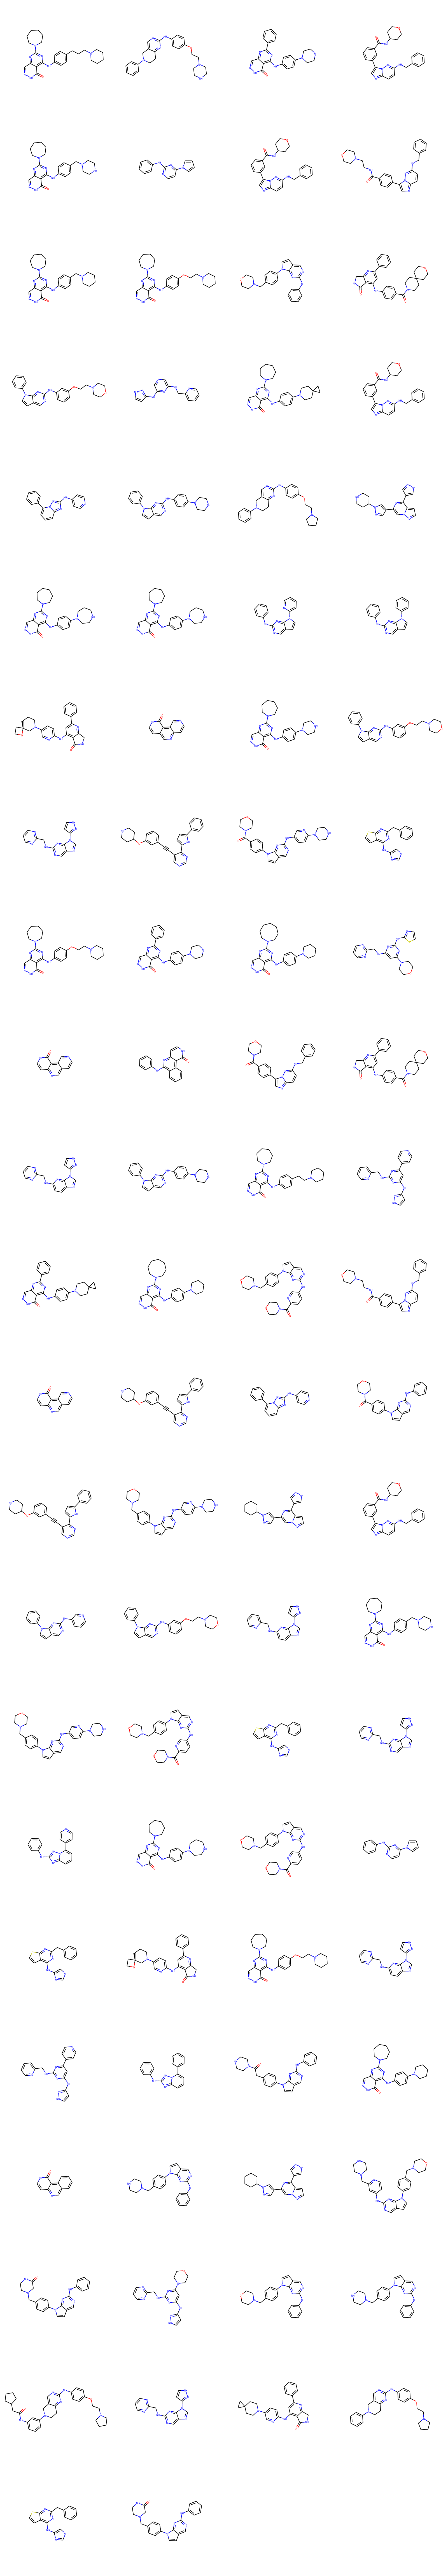

In [60]:
draw_smiles(list(common_scaffolds), [], 90)

701
0


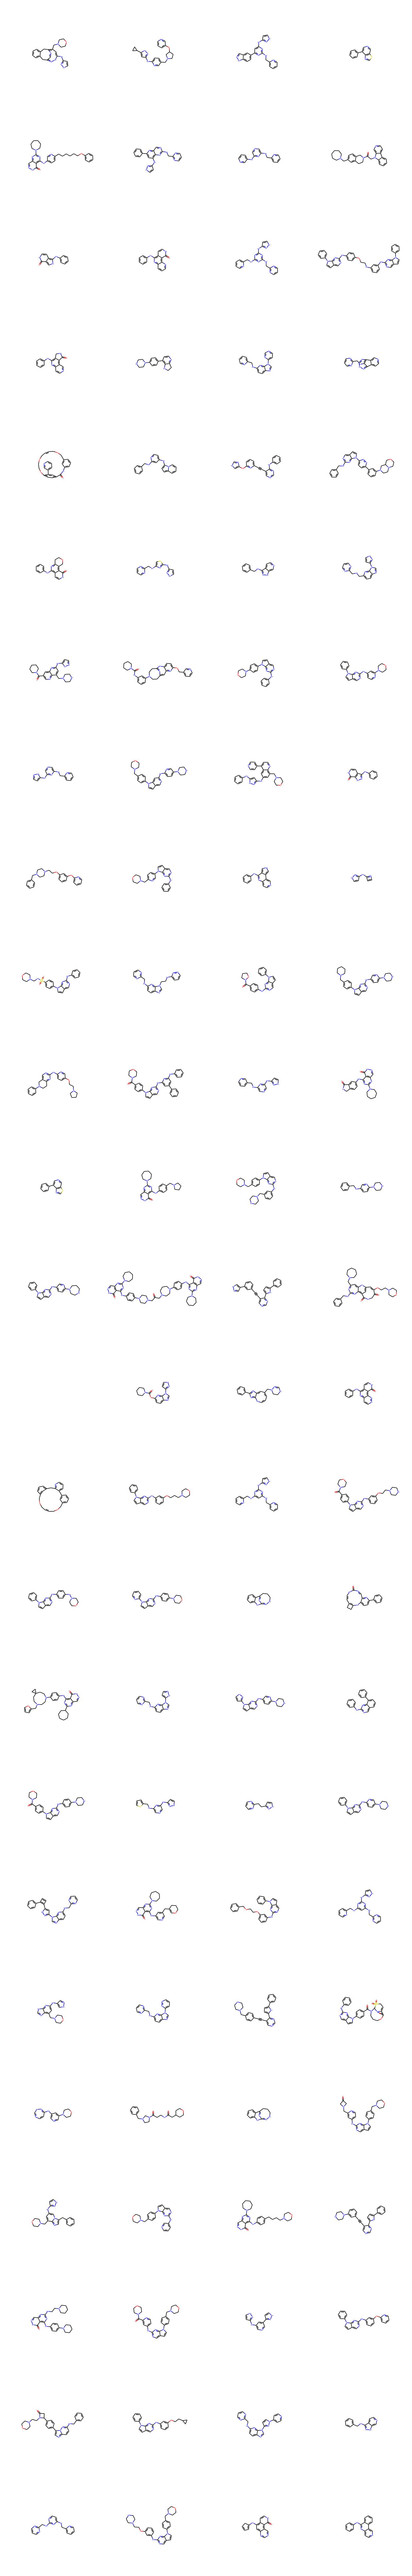

In [62]:
draw_smiles(list(unique_gen_scaffolds), [], 100)

In [85]:
unique_gen_scaffolds, buffer_scaffolds_set = list(unique_gen_scaffolds), list(buffer_scaffolds_set)
sim_m = calc_sim_ind_tanimoto(unique_gen_scaffolds, buffer_scaffolds_set)

In [84]:
sim_m.min()

0.0

In [92]:
most_different_gen_scaffolds = [unique_gen_scaffolds[i] for i in np.where(np.mean(sim_m, axis=0) < 0.25)[0]]

most_close_buffer_scaffolds = [[buffer_scaffolds_set[b_indx] for b_indx in sim_m[gen_indx].argsort()[-9:][::-1]] for gen_indx in np.where(np.mean(sim_m, axis=0) < 0.4)[0]]

len(most_different_gen_scaffolds)

21

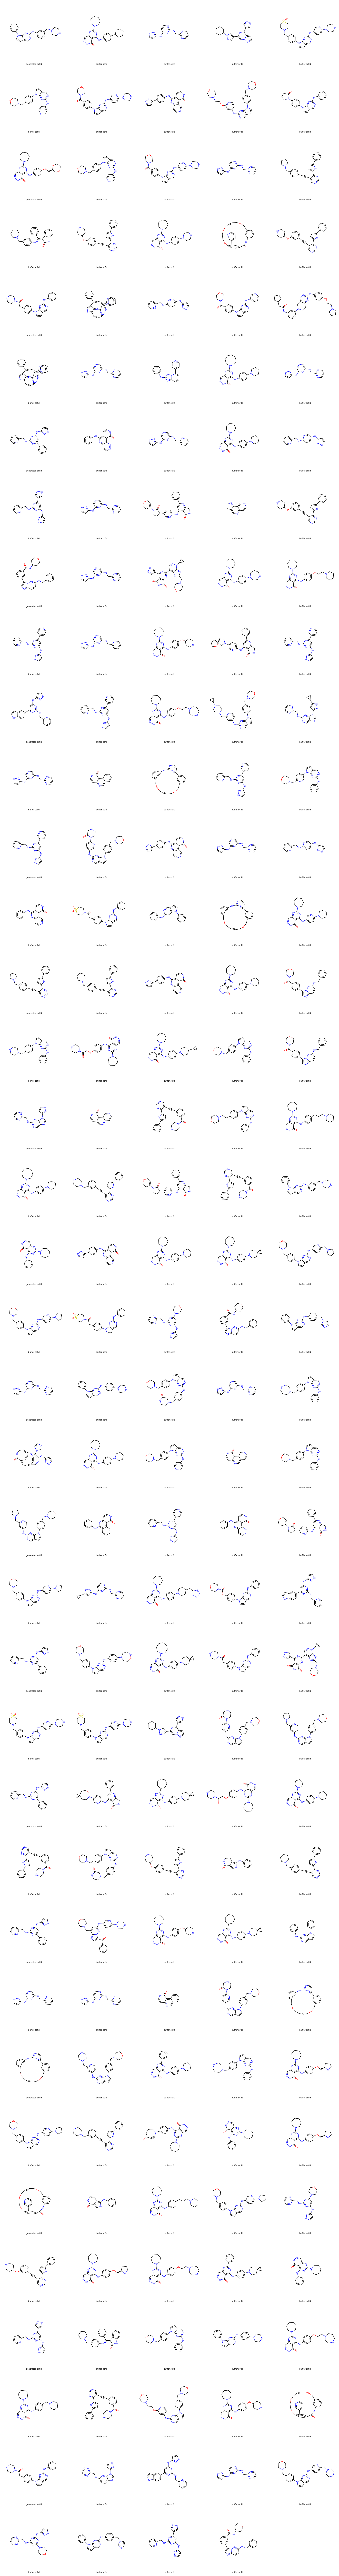

In [110]:
all_to_draw = []
all_legends = []
for i, sm in enumerate(most_different_gen_scaffolds):
    to_draw = [sm]
    to_draw.extend(most_close_buffer_scaffolds[i])
  
    legends = ['buffer scfld'] * len(most_close_buffer_scaffolds[i])
    legends.insert(0, 'generated scfld')
    all_to_draw.extend(to_draw)
    all_legends.extend(legends)

img = draw_smiles(all_to_draw, [], len(most_different_gen_scaffolds) * len(most_close_buffer_scaffolds[0]), all_legends)
img

# General stats

In [91]:
smiles_to_compare = []
for name, generator, gen_data in zip(['jak1', 'jak2', 'jak3'],
                                       [jak1_g, jak2_g, jak3_g], 
                                       [jak1_gen_data, jak2_gen_data, jak_3_gen_data],
                                      
                                      ):
    
    print(f'Generating {name}...')
    gen_smiles = generate_exact_number(generator, 5000, gen_data, 10, True)
    smiles_to_compare.append(gen_smiles)
    
    

Generating molecules...:   0%|          | 0/500 [00:00<?, ?it/s]

Generating jak1...


Generating molecules...:   0%|          | 0/500 [00:00<?, ?it/s]

Generating jak2...


Generating molecules...:   0%|          | 0/500 [00:00<?, ?it/s]

Generating jak3...


Generating molecules...: 100%|██████████| 500/500 [03:10<00:00,  2.62it/s]


In [92]:
for i, (name, generator, gen_data, buffer_smiles) in enumerate(zip(['jak1', 'jak2', 'jak3'],
                                       [jak1_g, jak2_g, jak3_g], 
                                       [jak1_gen_data, jak2_gen_data, jak_3_gen_data],
                                       [ jak_1_buffer_smiles,  jak_2_buffer_smiles,  jak_3_buffer_smiles]
                                      )):

#     gen_smiles, valid, unique = generate(generator, 5000, gen_data, 10)
    gen_scaffolds = [get_scaffold(sm) for sm in smiles_to_compare[i]]
    buffer_scaffolds = [get_scaffold(sm) for sm in buffer_smiles]
    buffer_scaffolds = [sm for sm in buffer_scaffolds if sm]
    gen_scaffolds_set = set(gen_scaffolds)
    buffer_scaffolds_set = set(buffer_scaffolds)
    
    common_scaffolds = gen_scaffolds_set & buffer_scaffolds_set
    unique_gen_scaffolds = gen_scaffolds_set - buffer_scaffolds_set
    unique_buffer_scaffolds =  buffer_scaffolds_set - gen_scaffolds_set
    all_scaffolds = gen_scaffolds_set | buffer_scaffolds_set

    print(f'{name}: Common scaffolds {len(common_scaffolds) / len(all_scaffolds) * 100} %,  unigue in buffer {len(unique_buffer_scaffolds) / len(all_scaffolds) * 100} %, unigue in generated {len(unique_gen_scaffolds) / len(all_scaffolds) * 100}')

jak1: Common scaffolds 1.5259895088221267 %,  unigue in buffer 0.14306151645207438 %, unigue in generated 98.3309489747258
jak2: Common scaffolds 6.741573033707865 %,  unigue in buffer 3.620474406991261 %, unigue in generated 89.63795255930087
jak3: Common scaffolds 14.50381679389313 %,  unigue in buffer 7.888040712468193 %, unigue in generated 77.60814249363868


In [ ]:
buffer_smiles_images = 
for buffer_smiles in [jak_1_buffer_smiles,  jak_2_buffer_smiles,  jak_3_buffer_smiles]:
    preds = np.array([p.predict(buffer_smiles, get_features=get_fp)[1] for p in [jak1_p_r, jak2_p_r, jak3_p_r]]).T
    draw_smiles(buffer_smiles, preds, mols_to_draw=preds.shape[0])

## Observe distribution change in scaffolds

In [124]:
buffer_scffs_dist_imgs = []
for buffer in [ jak_1_buffer_smiles,  jak_2_buffer_smiles,  jak_3_buffer_smiles]:
    buffer_scaffolds = [get_scaffold(sm) for sm in buffer]
    buffer_scaffolds = [sm for sm in buffer_scaffolds if sm]
    c = Counter(buffer_scaffolds)
    buff_img = draw_smiles([t[0] for t in c.most_common(40)], [], 40,
                   list(map(lambda x: f'{np.round(x * 100, 2)} %', [t[1] / len(buffer_scaffolds) for t in c.most_common(40)])))
    
    print(c.most_common(11)[6])
    print(c.most_common(11)[10])

    buffer_scffs_dist_imgs.append(buff_img)

('O=S(=O)(C[C@H]1C[C@@H](Nc2ncnc3[nH]ccc23)C1)N1CCCC1', 2)
('O=C(OCCN1CCCC1)N1CCC(n2ccc(Nc3ccccc3)n2)CC1', 2)
('c1cnc(CNc2nccc(Nc3cc[nH]n3)n2)nc1', 6)
('c1cc(Nc2ncc3ccn(-c4ccc(CN5CCOCC5)cc4)c3n2)cc(CN2CCNCC2)n1', 4)
('c1ccc(-c2c[nH]c3ncnc(-c4ccccc4)c23)cc1', 8)
('O=C1NCc2cnc(Nc3ccc(N4CCNCC4)cc3)nc2N1Cc1ccccc1', 4)


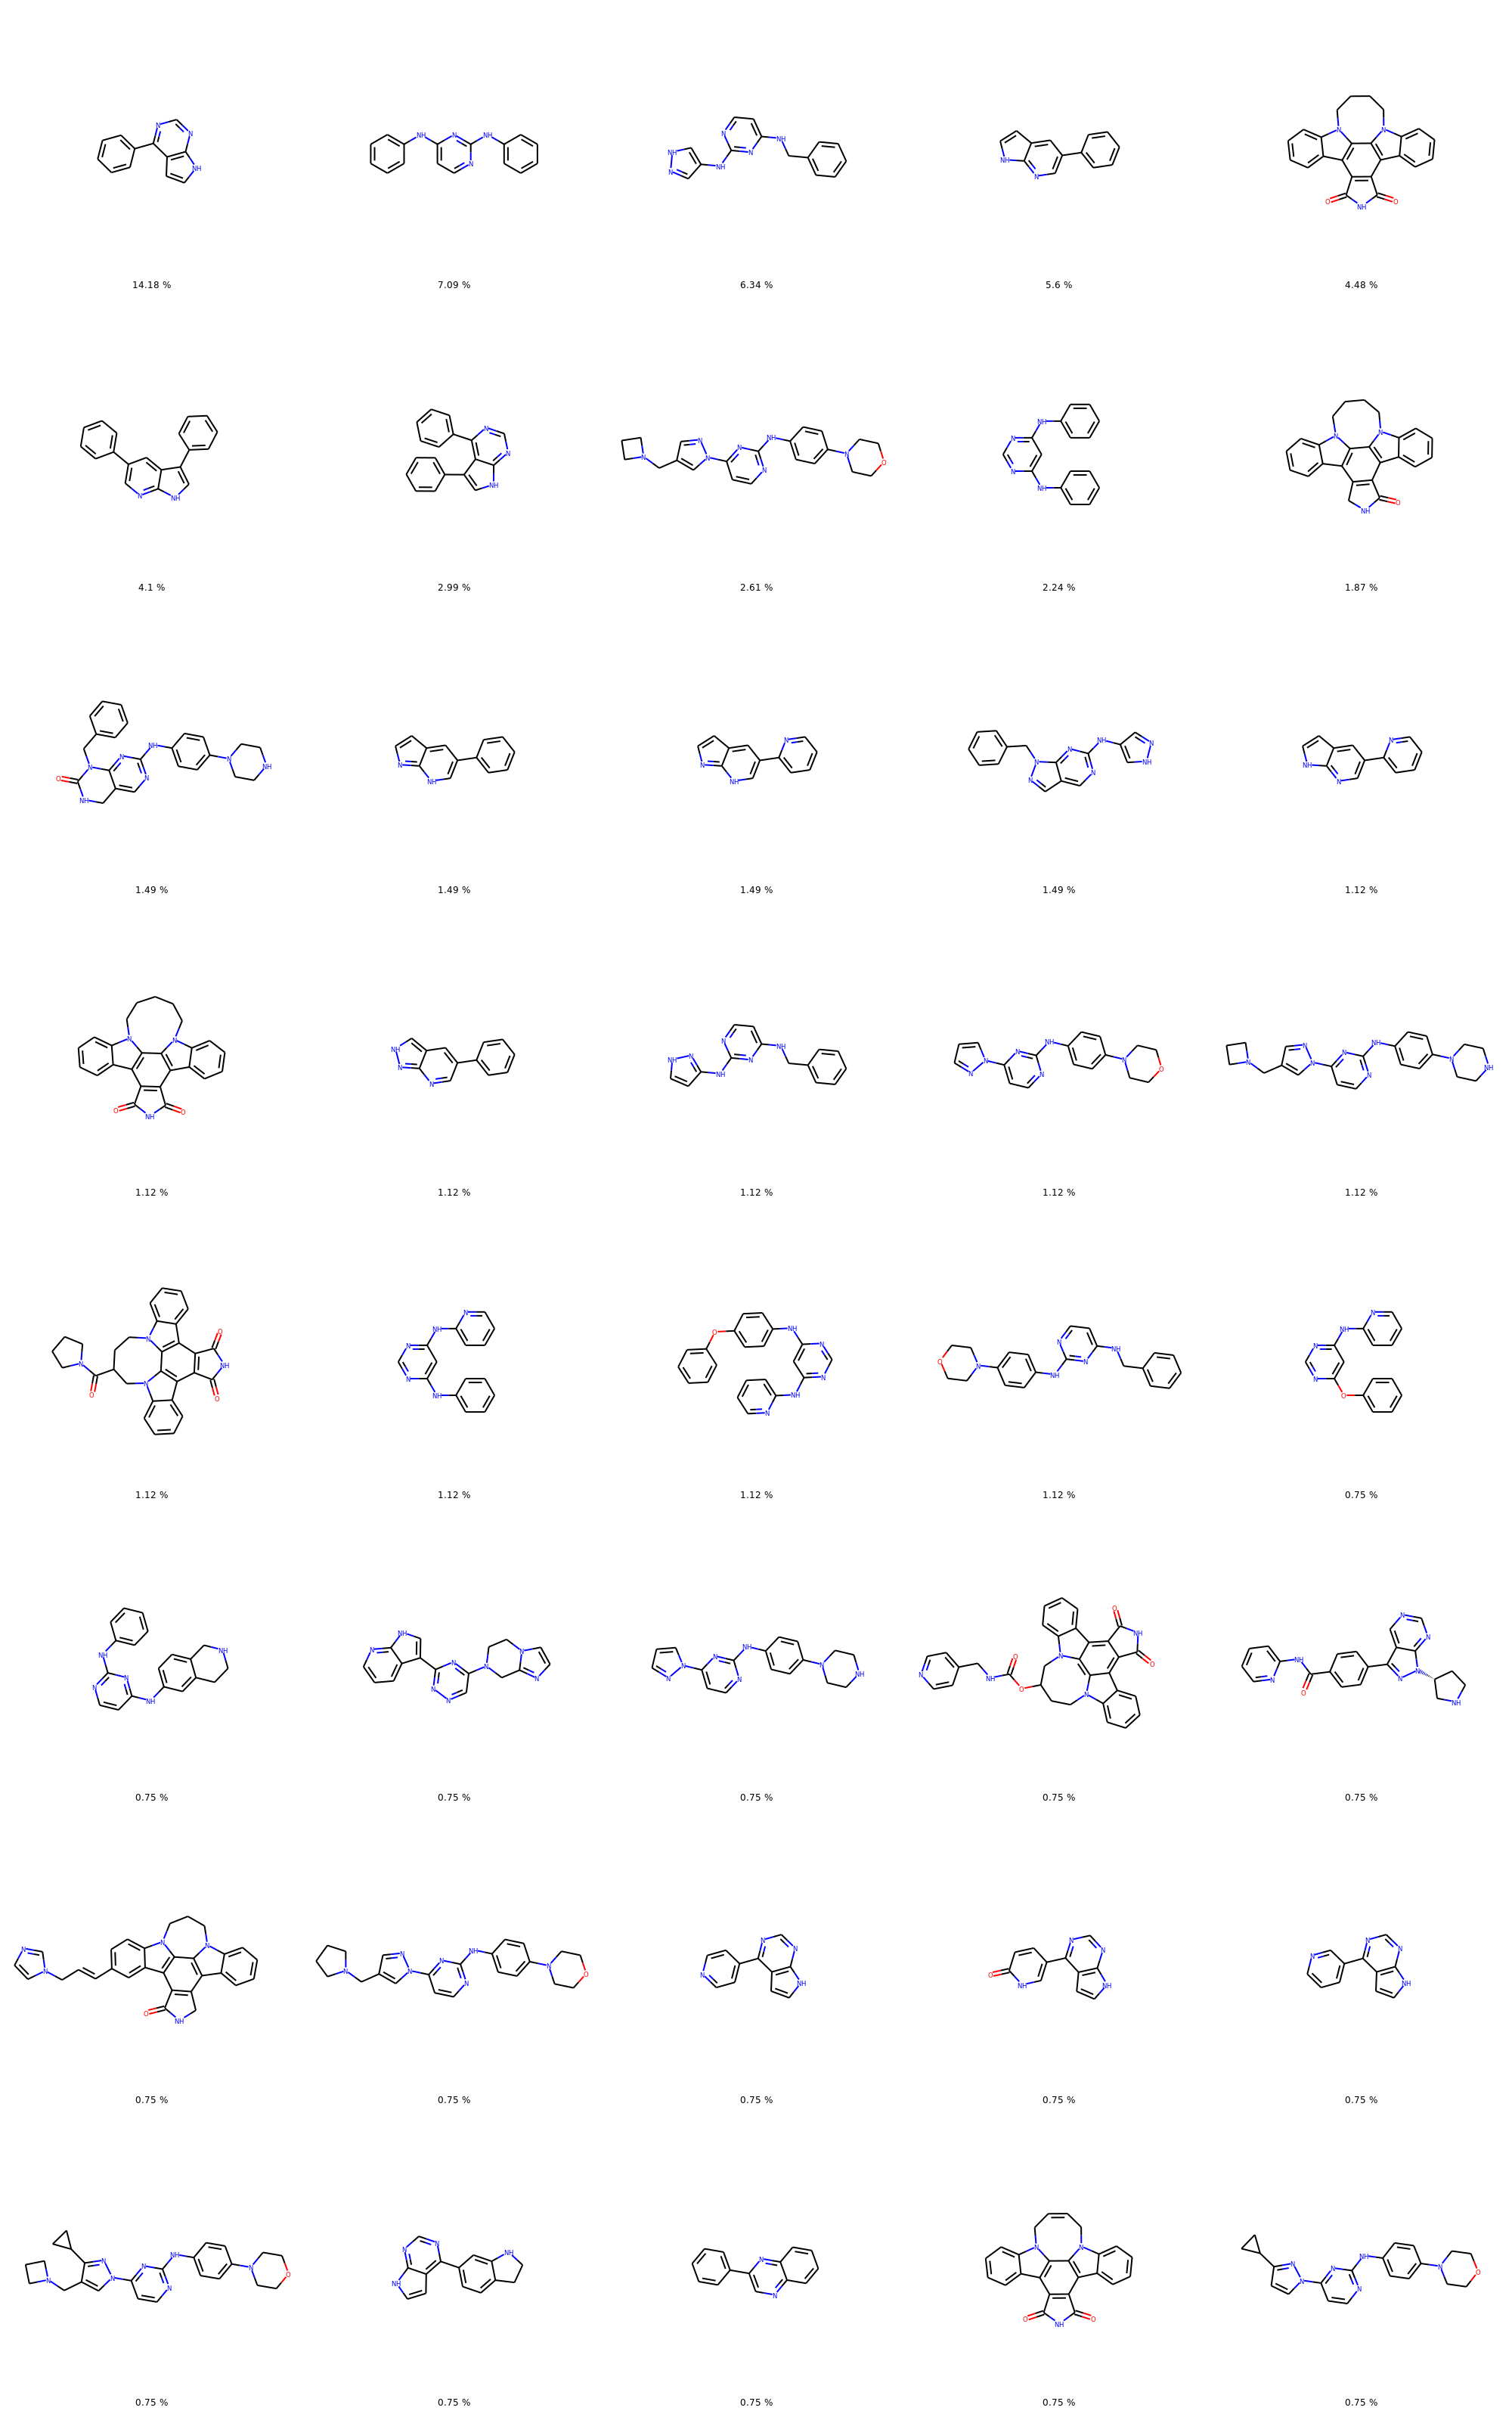

In [125]:
buffer_scffs_dist_imgs[2]

In [128]:
from collections import Counter

def draw_most_frequent_scaffolds(generator, gen_data, n_to_draw, label):
    gen_smiles = generate_exact_number(generator, 3000, gen_data, 10, False)
    gen_scaffolds = [get_scaffold(sm) for sm in smiles]
    c = Counter(gen_scaffolds)
    img = draw_smiles([t[0] for t in c.most_common(n_to_draw)], [], n_to_draw,
               list(map(lambda x: f'{np.round(x * 100, 2)} %', [t[1] / len(gen_scaffolds) for t in c.most_common(n_to_draw)])))
    return img
    

In [129]:
jak2_scffs_dist_imgs = []
for i in range(400, 3800,400):
    generator, gen_data = get_generator(f'./experiments/test_max_jak2_correct_rwd/generator_{i}.pth')
    img = draw_most_frequent_scaffolds(generator, gen_data, 20, '')
    jak2_scffs_dist_imgs.append(img)

clear_output()

for e, img in zip(np.arange(400, 3800,400), jak2_scffs_dist_imgs):
    img_2 = Image.fromarray(matplotlib.image.pil_to_array(img), 'RGB')
    img_2.save(f'experiments/test_max_jak2_correct_rwd/scaffold_images/img_epoch_{e}.png')
    

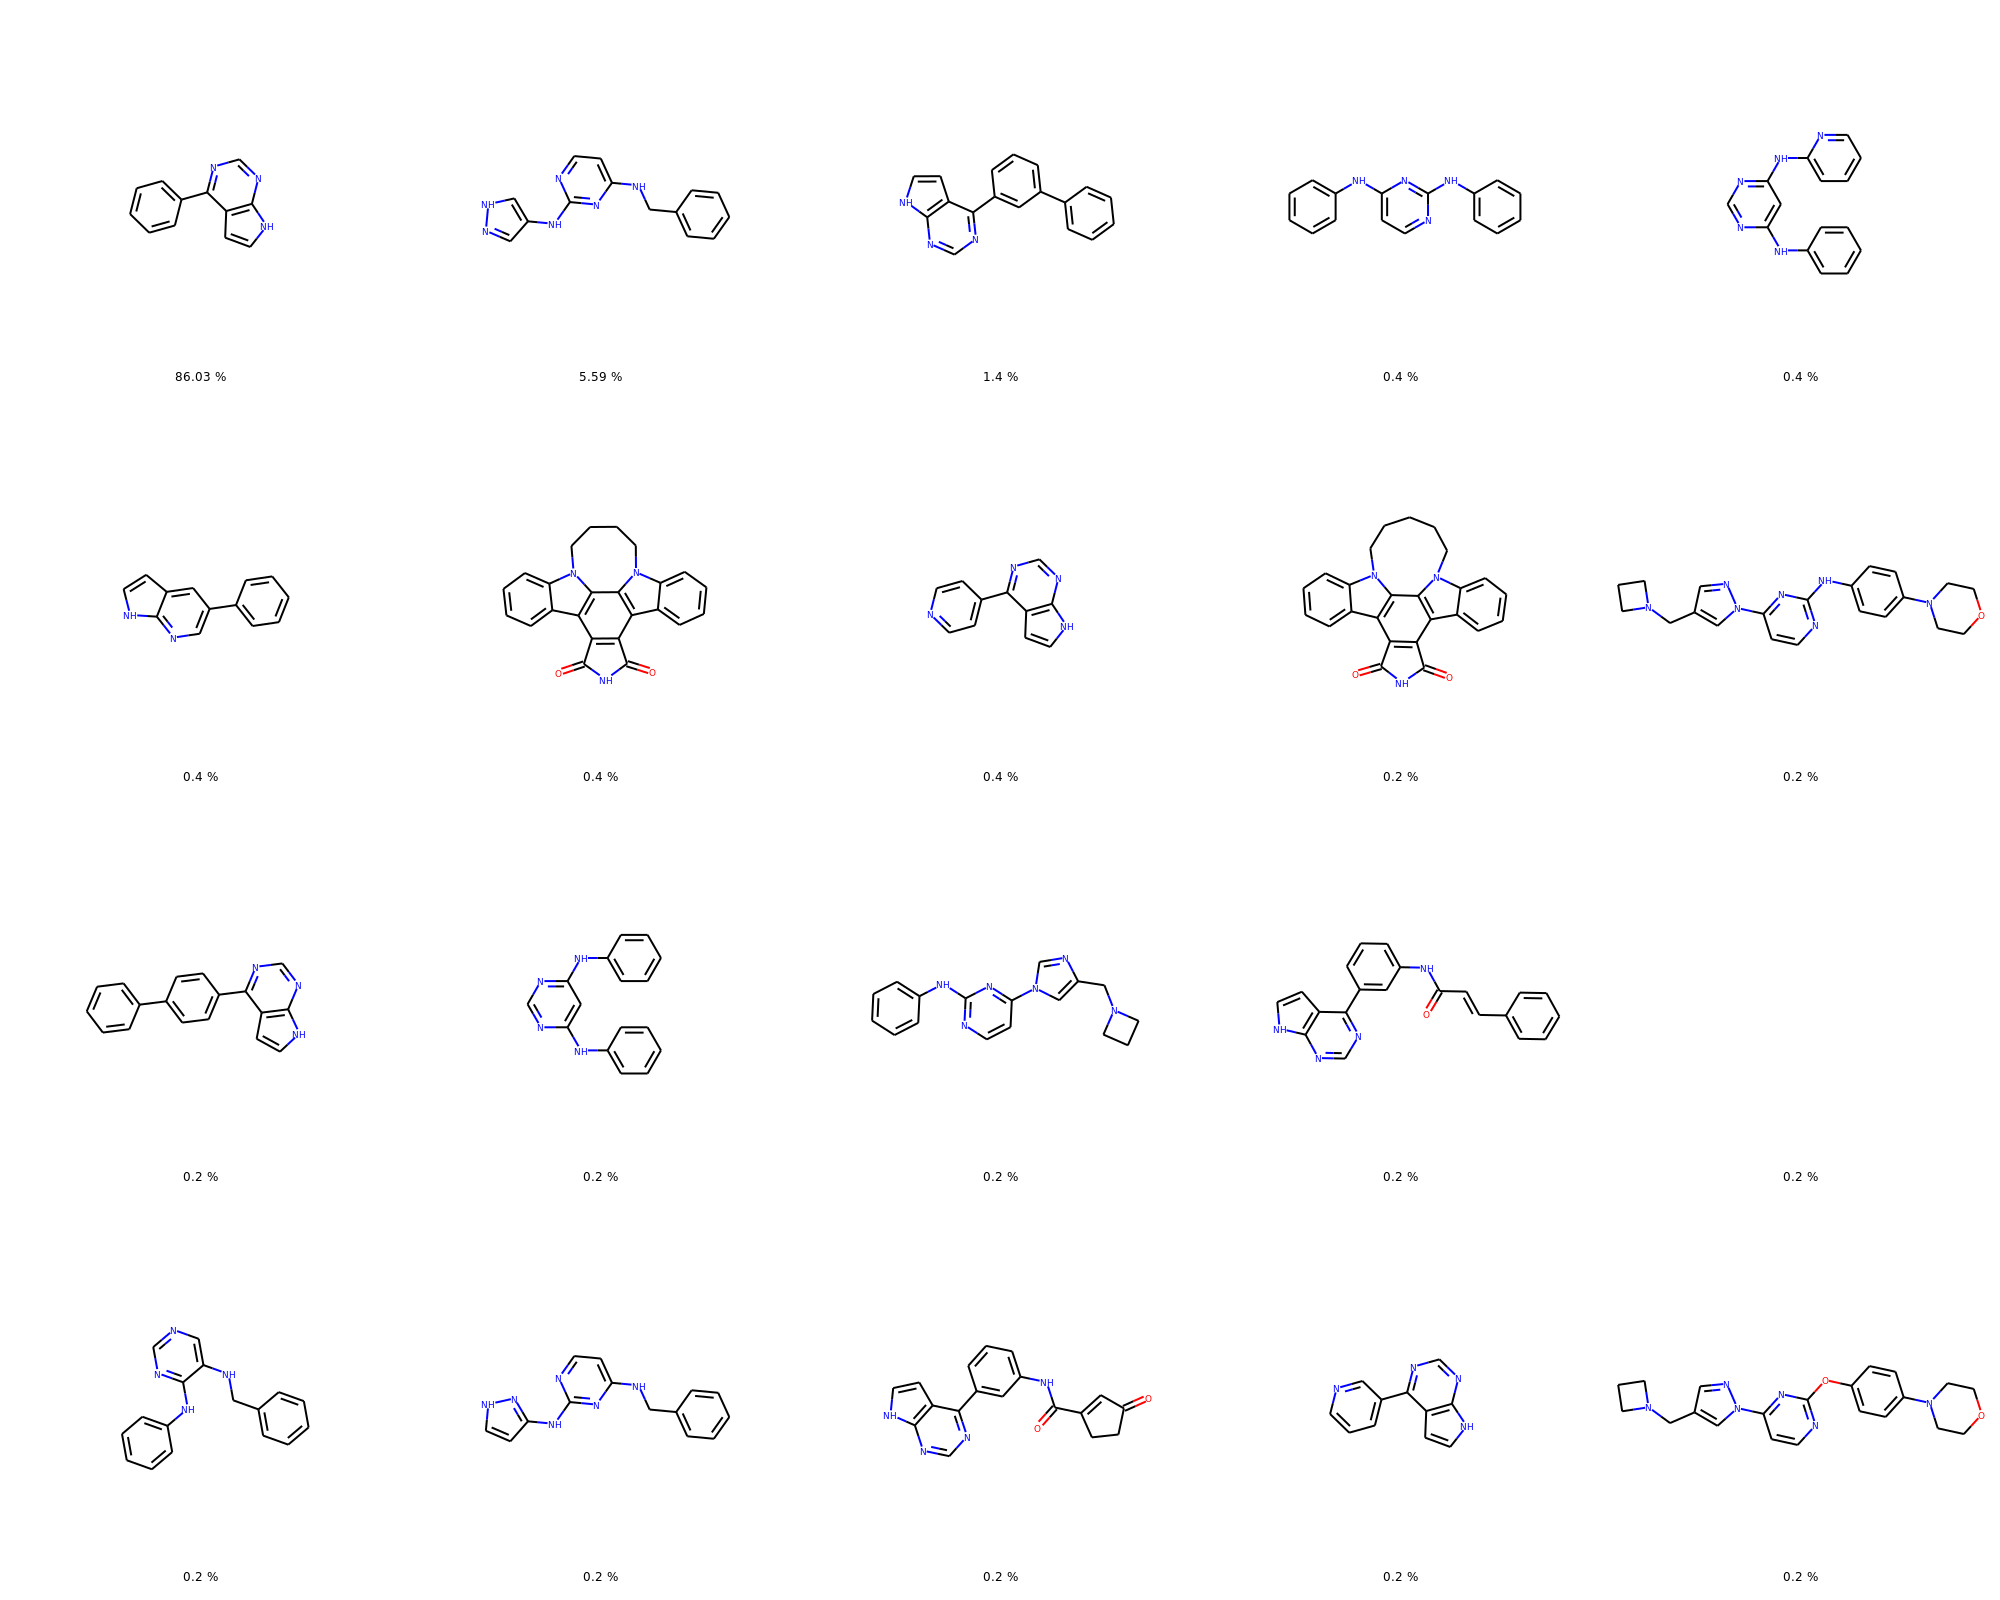

In [127]:
jak2_scffs_dist_imgs[2]

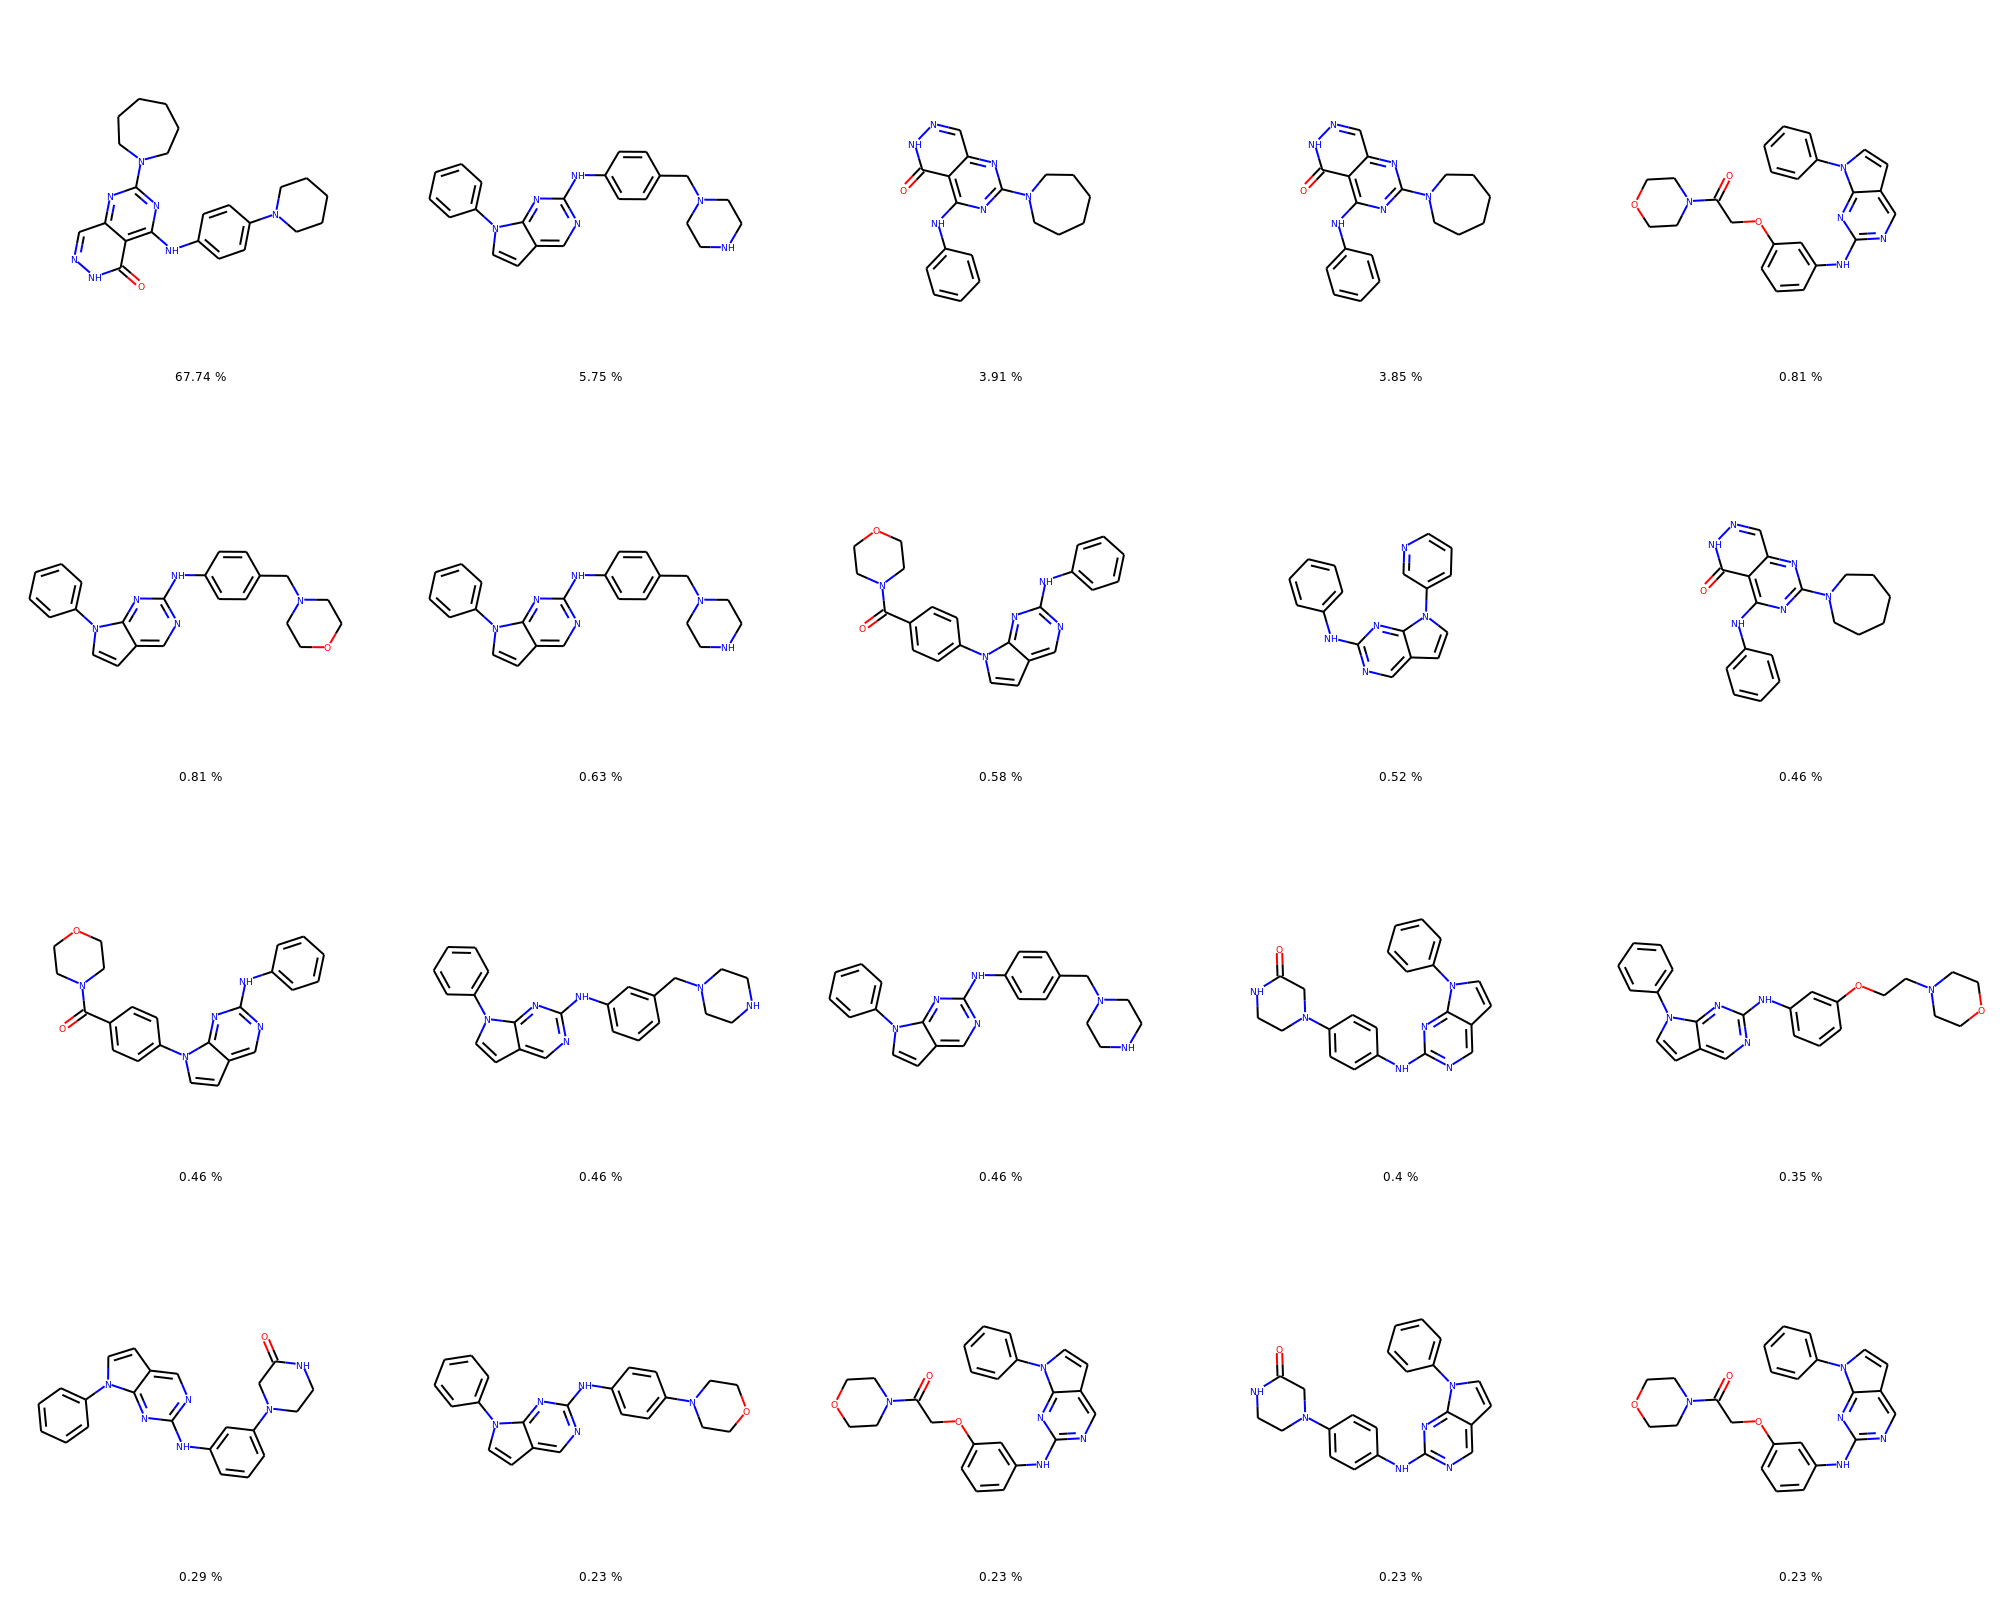

In [83]:
jak2_scffs_dist_imgs[2]

In [ ]:
jak1_scffs_dist_imgs = []
for i in range(400, 5000,400):
    generator, gen_data = get_generator(f'./experiments/test_max_jak1_correct_rwd/generator_{i}.pth')
    img = draw_most_frequent_scaffolds(generator, gen_data, 20, '')
    jak1_scffs_dist_imgs.append(img)

clear_output()

# os.mkdir('experiments/test_max_jak1_correct_rwd/scaffold_images/')
for e, img in zip(np.arange(400, 5000,400), jak1_scffs_dist_imgs):
    img_2 = Image.fromarray(matplotlib.image.pil_to_array(img), 'RGB')
    img_2.save(f'experiments/test_max_jak1_correct_rwd/scaffold_images/img_epoch_{e}.png')

Generating molecules...:   0%|          | 0/300 [00:00<?, ?it/s]

Loading generator from ./experiments/test_max_jak1_correct_rwd/generator_400.pth


Generating molecules...:   0%|          | 0/300 [00:00<?, ?it/s]

Loading generator from ./experiments/test_max_jak1_correct_rwd/generator_800.pth


Generating molecules...:  68%|██████▊   | 205/300 [01:16<00:31,  2.99it/s]

In [ ]:
jak3_scffs_dist_imgs = []
for i in range(400, 5000,400):
    generator, gen_data = get_generator(f'./experiments/test_max_jak3_correct_rwd/generator_{i}.pth')
    img = draw_most_frequent_scaffolds(generator, gen_data, 20, '')
    jak3_scffs_dist_imgs.append(img)

clear_output()

# os.mkdir('experiments/test_max_jak3_correct_rwd/scaffold_images/')
for e, img in zip(np.arange(400, 5000,400), jak3_scffs_dist_imgs):
    img_2 = Image.fromarray(matplotlib.image.pil_to_array(img), 'RGB')
    img_2.save(f'experiments/test_max_jak3_correct_rwd/scaffold_images/img_epoch_{e}.png')

## Explore difference in iC50

In [12]:
def get_predictor(model_type, model_class, model_params, path):
    model_instance = RFR if model_class == 'RFR' else CatBoostClassifier
    predictor = VanillaQSAR(model_instance=model_instance,
                       model_params=model_params,
                       model_type=model_type, model_class=model_class)


    predictor.load_model(path)
    return predictor

In [93]:
def get_ic50_deltas(names, smiles, predictors, n_to_generate):
    
    clear_output()
    preds = [p.predict(smiles, get_features=get_fp)[1] for p in predictors]
    plt.hist(preds[0] - preds[1], bins=50, alpha=0.5)
    plt.hist(preds[0] - preds[2], bins=50, alpha=0.5)
    plt.legend(labels=[f'Delta btw {names[0]} and {names[1]}', f'Delta btw {names[0]} and {names[2]}'])
    plt.title('Deltas between iC50 for JAKs')
    
    

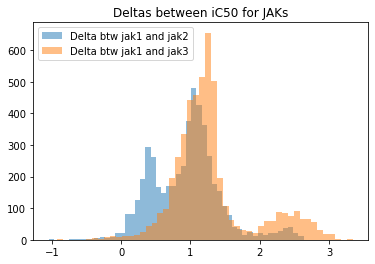

In [94]:
get_ic50_deltas(['jak1', 'jak2', 'jak3'], smiles_to_compare[0], [jak1_p_r, jak2_p_r, jak3_p_r], 2000)

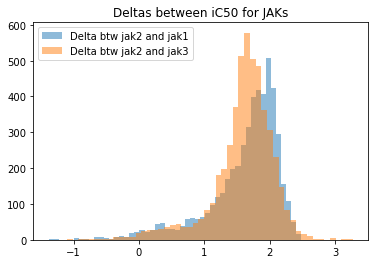

In [95]:
get_ic50_deltas(['jak2', 'jak1', 'jak3'], smiles_to_compare[1], [jak2_p_r, jak1_p_r, jak3_p_r], 2000)

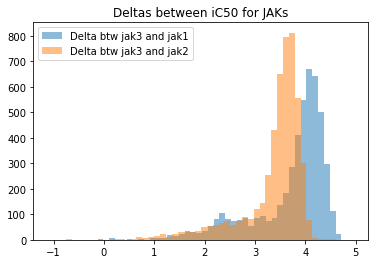

In [96]:
get_ic50_deltas(['jak3', 'jak1', 'jak2'], smiles_to_compare[2], [jak3_p_r, jak1_p_r, jak2_p_r], 2000)

# Compare champion molecules from three receptors

In [97]:
smiles_to_compare_df = pd.concat((pd.DataFrame.from_dict({'SMILES' : smiles_to_compare[0], 'target': ['jak1'] * len(smiles_to_compare[0])}),
                                  pd.DataFrame.from_dict({'SMILES' : smiles_to_compare[1], 'target': ['jak2'] * len(smiles_to_compare[1])}),
                                  pd.DataFrame.from_dict({'SMILES' : smiles_to_compare[2], 'target': ['jak3'] * len(smiles_to_compare[2])})
                                 )).reset_index(drop=True)
smiles_to_compare_df['jak1'] = pd.Series(jak1_p_r.predict(smiles_to_compare_df['SMILES'].values, get_features=get_fp)[1])
smiles_to_compare_df['jak2'] = pd.Series(jak2_p_r.predict(smiles_to_compare_df['SMILES'].values, get_features=get_fp)[1])
smiles_to_compare_df['jak3'] = pd.Series(jak3_p_r.predict(smiles_to_compare_df['SMILES'].values, get_features=get_fp)[1])

In [109]:
smiles_to_compare_df.to_csv('experiments/test_max_jak2_correct_rwd/generated_smiles_all_jaks.csv', index=False)

## by max delta

In [98]:
smiles_to_compare_df['delta wrt jak1'] =  smiles_to_compare_df[['jak1', 'jak2', 'jak3']].apply(
                                                                                        lambda x: 2 * x['jak1'] - x['jak2'] - x['jak3'], axis=1)
smiles_to_compare_df['delta wrt jak2'] =  smiles_to_compare_df[['jak1', 'jak2', 'jak3']].apply(
                                                                                        lambda x: 2 * x['jak2'] - x['jak1'] - x['jak3'], axis=1)

smiles_to_compare_df['delta wrt jak3'] =  smiles_to_compare_df[['jak1', 'jak2', 'jak3']].apply(
                                                                                        lambda x: 2 * x['jak3'] - x['jak1'] - x['jak2'], axis=1)

imgs_by_max_delta = []
for i, name in enumerate(['jak1', 'jak2', 'jak3']):
    best_smiles = smiles_to_compare_df[smiles_to_compare_df['target'] == name].sort_values(by=[f'delta wrt {name}'], ascending=False).head(100)
    img = draw_smiles(best_smiles['SMILES'].values, best_smiles[['jak1', 'jak2', 'jak3']].to_numpy(), mols_to_draw=100)
    imgs_by_max_delta.append(img)
    
  


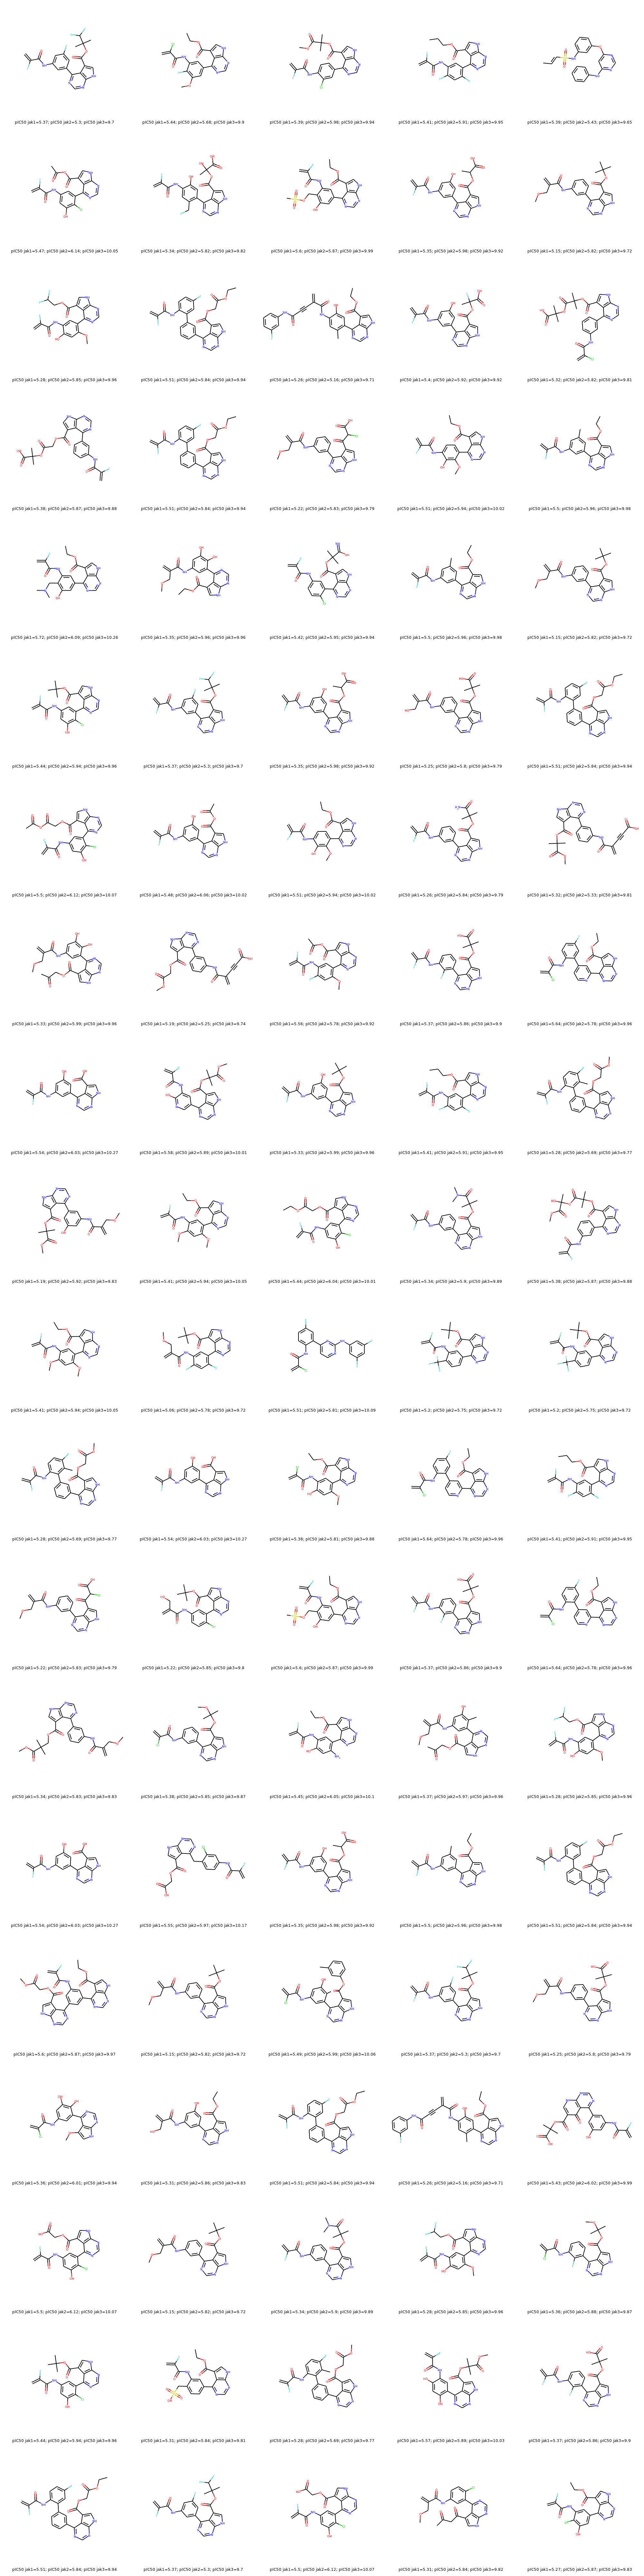

In [102]:
imgs_by_max_delta[2]

## by strongest binding to target

In [103]:
imgs_by_max_ic50 = []
for i, name in enumerate(['jak1', 'jak2', 'jak3']):
    best_smiles = smiles_to_compare_df[smiles_to_compare_df['target'] == name].sort_values(by=[f'{name}'], ascending=False).head(100)
    img = draw_smiles(best_smiles['SMILES'].values, best_smiles[['jak1', 'jak2', 'jak3']].to_numpy(), mols_to_draw=100)
    imgs_by_max_ic50.append(img)

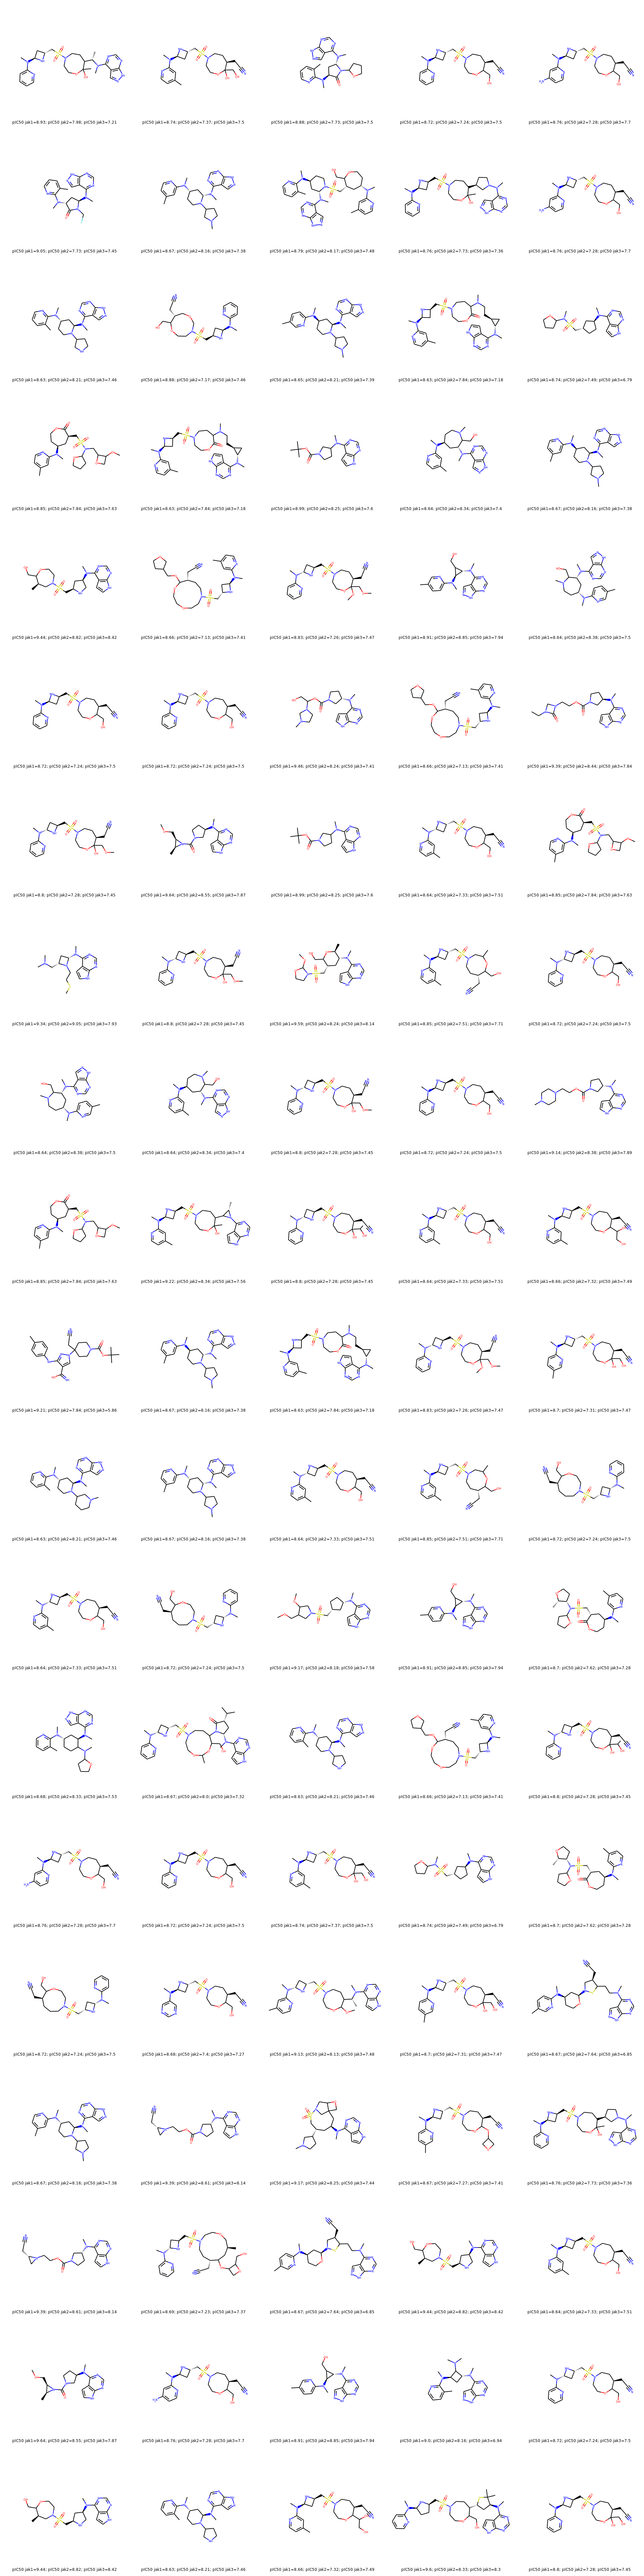

In [104]:
imgs_by_max_ic50[0]

## most different from buffer

## by max RL reward

## compare deltas btw known molecules